#Install Library

In [1]:
import os
import random
import gdown
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sn
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# Upload API Kaggle (JSON)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gloriarustama","key":"ce50521b43596f771cf655d6ae1771ad"}'}

#Collect Dataset

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d agungmrf/indonesian-sign-language-bisindo
!mkdir dataset
!unzip -qq indonesian-sign-language-bisindo.zip -d dataset

Dataset URL: https://www.kaggle.com/datasets/agungmrf/indonesian-sign-language-bisindo
License(s): unknown
 99% 1.35G/1.36G [00:09<00:00, 146MB/s]
100% 1.36G/1.36G [00:09<00:00, 159MB/s]


In [4]:
INPUT_SIZE = (224, 224)
BATCH_SIZE = 32
TRAIN_DIR = '/content/dataset/bisindo/images/train'
VALIDATION_DIR = '/content/dataset/bisindo/images/val'

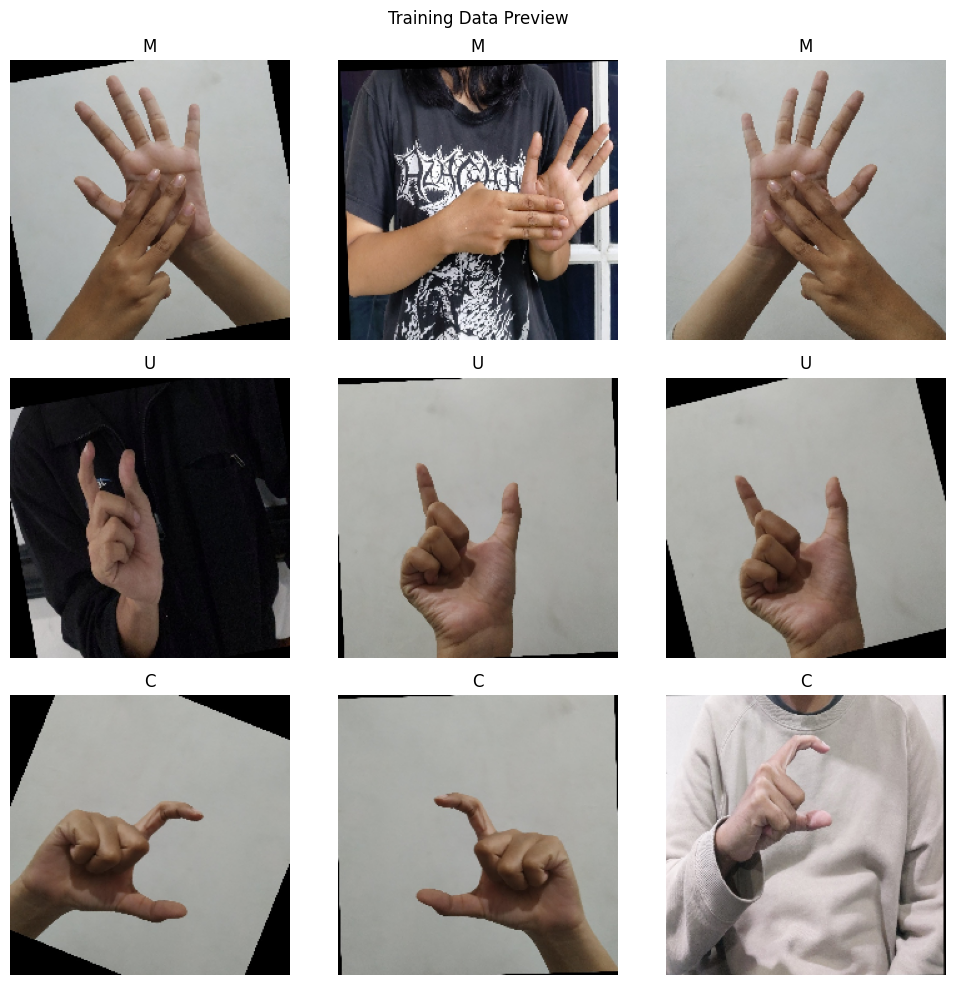

In [5]:
labels = os.listdir(TRAIN_DIR)
plt.figure(figsize=(10, 10))
num_rows = 3
num_cols = 3

for i, label in enumerate(labels):
    label_dir = os.path.join(TRAIN_DIR, label)
    images = os.listdir(label_dir)
    selected_images = random.sample(images, 9)
    for j, image_name in enumerate(selected_images):
        if i * num_cols + j >= num_rows * num_cols:
            break
        image_path = os.path.join(label_dir, image_name)
        img = image.load_img(image_path, target_size=(224, 224))
        plt.subplot(num_rows, num_cols, i * num_cols + j + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

plt.suptitle('Training Data Preview')
plt.tight_layout()
plt.show()

#Preprocessing Data

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=INPUT_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              target_size=INPUT_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='categorical')

Found 9169 images belonging to 26 classes.
Found 2301 images belonging to 26 classes.


In [7]:
NUM_CLASSES = len(train_generator.class_indices)
NUM_CLASSES

26

#Build Model

In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE[0], INPUT_SIZE[1], 3))
base_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
preds = Dense(26, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[0][0]']        

# Freeze

In [11]:
for layer in model.layers[:-5]:
    layer.trainable = False

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[0][0]']        

#Trainning Model

In [13]:
epochs = 10

optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs)

Epoch 1/10
287/287 [==============================] - 178s 594ms/step - loss: 0.9489 - accuracy: 0.7348 - val_loss: 0.5120 - val_accuracy: 0.8392
Epoch 2/10
287/287 [==============================] - 180s 627ms/step - loss: 0.4549 - accuracy: 0.8559 - val_loss: 0.3544 - val_accuracy: 0.8857
Epoch 3/10
287/287 [==============================] - 159s 555ms/step - loss: 0.3436 - accuracy: 0.8867 - val_loss: 0.3012 - val_accuracy: 0.9005
Epoch 4/10
287/287 [==============================] - 164s 570ms/step - loss: 0.2918 - accuracy: 0.9035 - val_loss: 0.3874 - val_accuracy: 0.8757
Epoch 5/10
287/287 [==============================] - 174s 608ms/step - loss: 0.2725 - accuracy: 0.9078 - val_loss: 0.2601 - val_accuracy: 0.9109
Epoch 6/10
287/287 [==============================] - 155s 540ms/step - loss: 0.2343 - accuracy: 0.9231 - val_loss: 0.2444 - val_accuracy: 0.9140
Epoch 7/10
287/287 [==============================] - 164s 572ms/step - loss: 0.2194 - accuracy: 0.9298 - val_loss: 0.2538 -

In [14]:
class EarlyStoppingAtGivenAccuracy(tf.keras.callbacks.Callback):
  def __init__(self, threshold):
    super().__init__()
    self.threshold = threshold

  def on_epoch_end(self, epoch, logs=None):
    if logs.get('accuracy') >= self.threshold:
      print(f"\nReached {self.threshold*100}% accuracy so stopping training!")
      self.model.stop_training = True

In [15]:
model.compile(
    optimizer = Adam(learning_rate = 1e-5),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

callback = EarlyStoppingAtGivenAccuracy(0.98)
history2 = model.fit(
    train_generator,
    validation_data = validation_generator,
    initial_epoch = 10,
    epochs = 20,
    callbacks = [callback]
)

Epoch 11/20
287/287 [==============================] - 160s 540ms/step - loss: 0.1157 - accuracy: 0.9617 - val_loss: 0.1452 - val_accuracy: 0.9500
Epoch 12/20
287/287 [==============================] - 157s 546ms/step - loss: 0.0965 - accuracy: 0.9696 - val_loss: 0.1375 - val_accuracy: 0.9505
Epoch 13/20
287/287 [==============================] - 155s 540ms/step - loss: 0.0905 - accuracy: 0.9719 - val_loss: 0.1350 - val_accuracy: 0.9513
Epoch 14/20
287/287 [==============================] - 155s 541ms/step - loss: 0.0869 - accuracy: 0.9703 - val_loss: 0.1323 - val_accuracy: 0.9522
Epoch 15/20
287/287 [==============================] - 159s 554ms/step - loss: 0.0807 - accuracy: 0.9731 - val_loss: 0.1295 - val_accuracy: 0.9531
Epoch 16/20
287/287 [==============================] - 157s 549ms/step - loss: 0.0820 - accuracy: 0.9743 - val_loss: 0.1273 - val_accuracy: 0.9557
Epoch 17/20
287/287 [==============================] - 161s 560ms/step - loss: 0.0709 - accuracy: 0.9764 - val_loss: 0

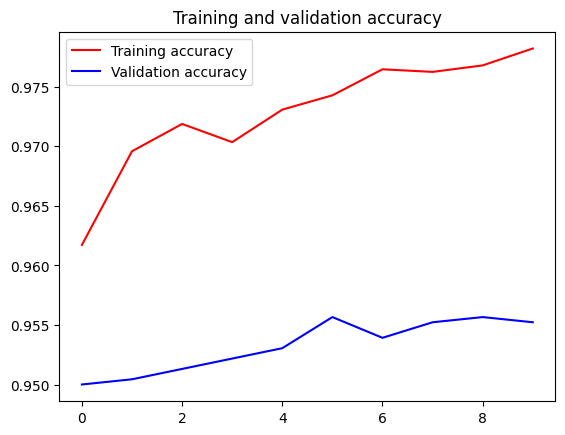

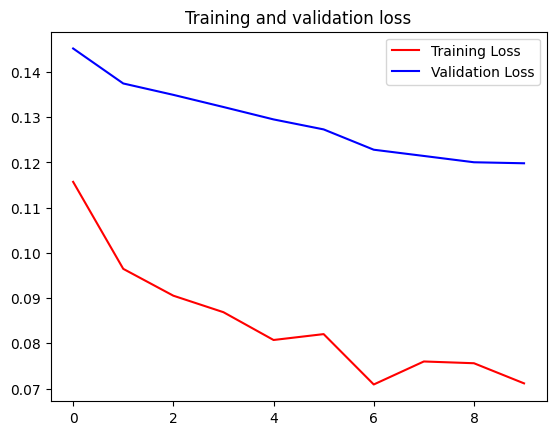

In [16]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Prediction Model

In [17]:
def preprocess_image(img_path, target_size=INPUT_SIZE):
  img = image.load_img(img_path, target_size=target_size)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input(img_array)
  return img_array

def classify_image(img_path, model):
  img_array = preprocess_image(img_path)
  predictions = model.predict(img_array)
  predicted_class_index = np.argmax(predictions, axis=1)[0]
  class_labels = {v: k for k, v in train_generator.class_indices.items()}
  predicted_class_label = class_labels[predicted_class_index]
  return predicted_class_label, predictions[0][predicted_class_index]

def display_prediction(img_path, model):
  predicted_label, confidence = classify_image(img_path, model)
  img = image.load_img(img_path, target_size=INPUT_SIZE)
  plt.imshow(img)
  plt.title(f"Predicted: {predicted_label}, Confidence: {confidence:.2f}")
  plt.axis('off')
  plt.show()

1/1 [==============================] - 2s 2s/step


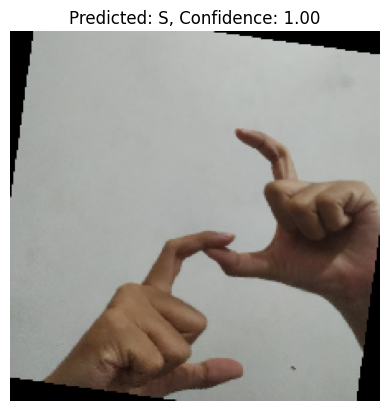

In [18]:
test_label = random.choice(os.listdir(VALIDATION_DIR))
test_image_dir = os.path.join(VALIDATION_DIR, test_label)
test_image_path = os.path.join(test_image_dir, random.choice(os.listdir(test_image_dir)))
display_prediction(test_image_path, model)

# Confusion Matrix

In [19]:
true_labels = validation_generator.classes
predictions = model.predict(validation_generator, steps=len(validation_generator), verbose=1)

cm = confusion_matrix(y_true=true_labels, y_pred=np.argmax(predictions, axis=1))

72/72 [==============================] - 12s 152ms/step


In [20]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

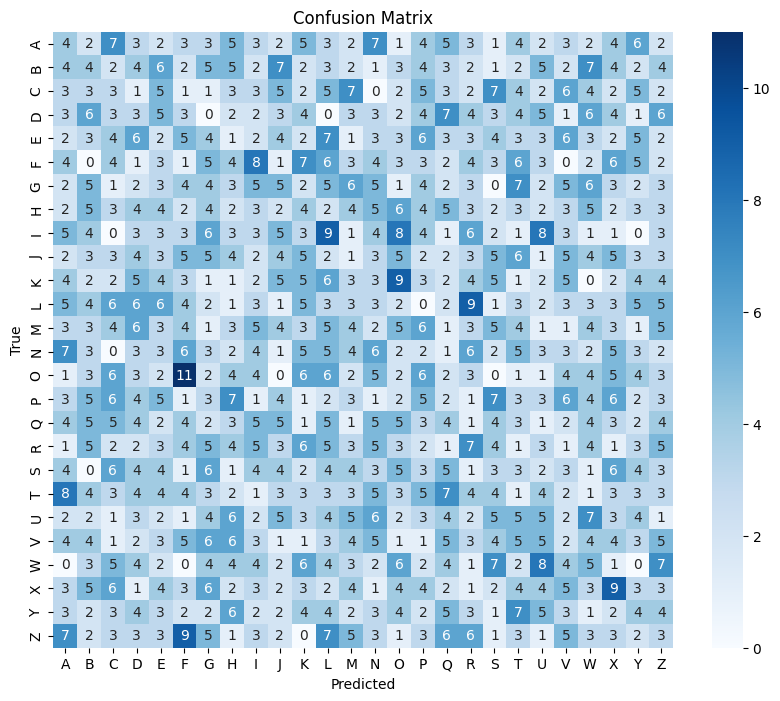

In [21]:
# Get class names
class_names = list(validation_generator.class_indices.keys())

# Plot
plot_confusion_matrix(cm, class_names)

#Save Model

In [27]:
model.save('handsign_model.h5')
files.download('handsign_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Convert Using TFLite's Converter

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('handsign_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [29]:
try:
    files.download('handsign_model.tflite')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>